In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
TextFileReader = pd.read_csv('household_power_consumption.txt',sep=';',header=0,chunksize=500000, low_memory=False)  # the number of rows per chunk

dfList = []
for df in TextFileReader:
    dfList.append(df)

df = pd.concat(dfList,sort=False)

In [4]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
Date                     object
Time                     object
Global_active_power      object
Global_reactive_power    object
Voltage                  object
Global_intensity         object
Sub_metering_1           object
Sub_metering_2           object
Sub_metering_3           float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [6]:
df.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [7]:
#The initial data contains several variables. 
#We will here focus on a single value : a house’s Global_active_power history, 
#that is, household global minute-averaged active power in kilowatt.

Data preprocessing

In [8]:
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['date_time']=pd.to_datetime(df['date_time']) 

df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df.dropna(subset=['Global_active_power'])

df['year'] = df['date_time'].dt.year
df['quarter'] = df['date_time'].dt.quarter
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day

df=df.loc[:,['date_time','Global_active_power', 'year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)

print('The time series starts from: ', df.date_time.min())
print('The time series ends on: ', df.date_time.max())

The time series starts from:  2006-12-16 17:24:00
The time series ends on:  2010-12-11 23:59:00


In [15]:
df.head()

,date_time,Global_active_power,year,quarter,month,day
0,2006-12-16 17:24:00,4.216,2006,4,12,16
1,2006-12-16 17:25:00,5.360,2006,4,12,16
2,2006-12-16 17:26:00,5.374,2006,4,12,16
3,2006-12-16 17:27:00,5.388,2006,4,12,16
4,2006-12-16 17:28:00,3.666,2006,4,12,16


Check the Normality of the variable

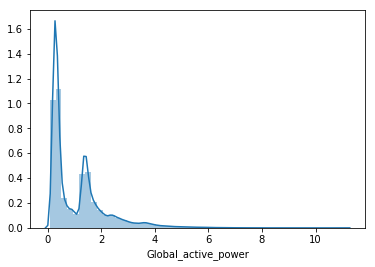

In [9]:
sb.distplot(df['Global_active_power'])

In [25]:
from scipy import stats
print( 'Kurtosis : {}'.format(stats.kurtosis(df.Global_active_power)))
print( 'Skewness : {}'.format(stats.skew(df.Global_active_power)))

Kurtosis : 4.218671866132129
Skewness : 1.7862320846320843


In [12]:
#Kurtosis has deviated from 0
#Skewness is more than 1
#Normality has been vioalated

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0,1.091615,1.057294,0.076,0.308,0.602,1.528,11.122


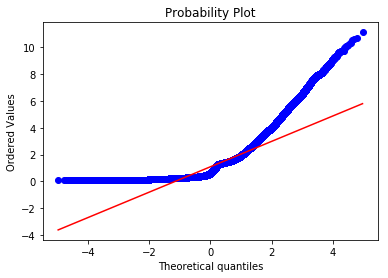

In [18]:
df1=df.loc[:,['date_time','Global_active_power']]
stats.probplot(df['Global_active_power'],plot=plt);
df1.describe().T

In [14]:
#Normal probability plot also shows the data is far from normally distributed.

#### Average Global Active Power Resampled Over Day, Week, Month, Quarter and Year

In [20]:
df1.set_index('date_time', inplace=True)

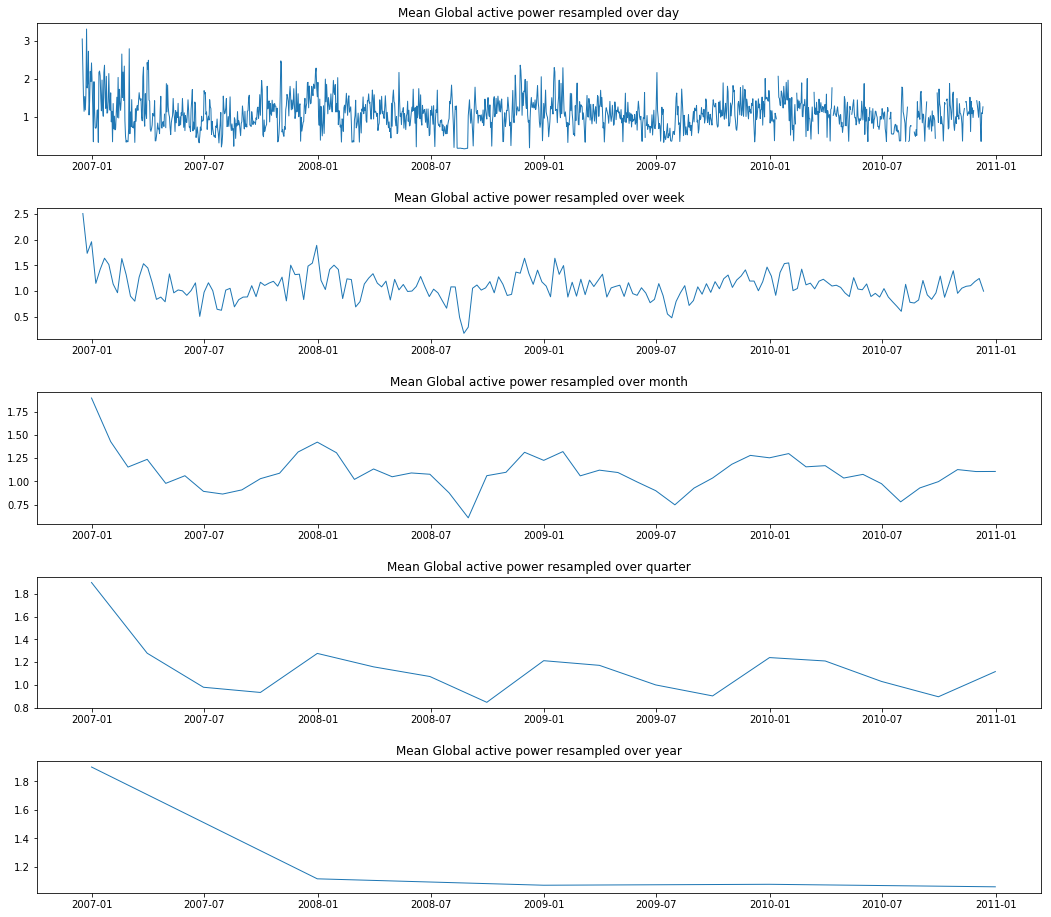

In [21]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Global_active_power'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global active power resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Global_active_power'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global active power resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Global_active_power'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global active power resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Global_active_power'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global active power resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['Global_active_power'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Global active power resampled over year')
ax5.tick_params(axis='both', which='major');

In [22]:
#In general, our time series does not have a upward or downward trend. 
#according to 'Mean Global active power resampled over year', highest average power consumption seems to be prior to 2007, 
#it was because we had only December data in 2006 and that month was a high consumption month. 
#if we compare year by year, it has been steady.

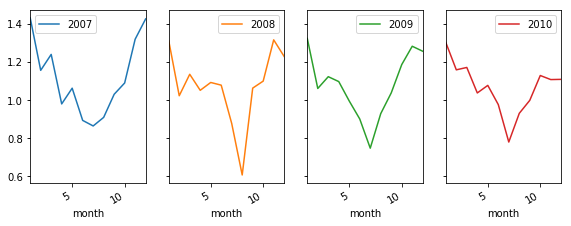

In [24]:
#Check Yearly consumption removing 2006
pd.pivot_table(df.loc[df['year'] != 2006], values = "Global_active_power", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True)
plt.show()

Global Active Power by Weekday vs. Weekend

In [26]:
df['day'] = df['date_time'].dt.dayofweek

In [30]:
df['weekday'] = df['day'].apply(lambda x: 'weekday' if x<5 else 'weekend')

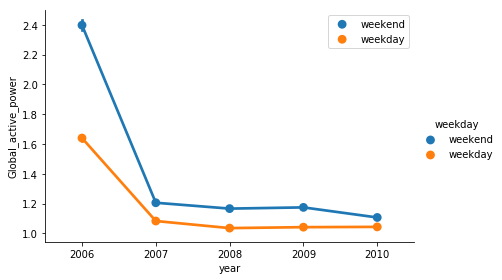

In [31]:
sb.factorplot('year','Global_active_power',hue='weekday',data=df, size=4, aspect=1.5)   
plt.legend(loc='upper right')

In [32]:
#power consumption on weekends is higher than weekdays

#### Stationarity check - Dickey-Fuller test

In [33]:
#H0: time series is non-stationary
#H1: time series is stationary. It does not have time-dependent structure.

In [37]:
df2=df1.resample('D', how=np.mean)
df3 = df2[df2['Global_active_power'].notnull()]

#perform Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

print ('Results of Dickey-Fuller test :')

dftest = adfuller(df3['Global_active_power'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test statistic','p-value','# Lags used','No of observations used'])

for key,value in dftest[4].items():
    dfoutput ['Critical value (%s)'%key] = value

print(dfoutput)
    

Results of Dickey-Fuller test :
Test statistic            -8.327686e+00
p-value                    3.435135e-13
# Lags used                9.000000e+00
No of observations used    1.423000e+03
Critical value (1%)       -3.434954e+00
Critical value (5%)       -2.863573e+00
Critical value (10%)      -2.567852e+00
dtype: float64


In [38]:
#accoding to test results we reject H0 and the time series is stationary

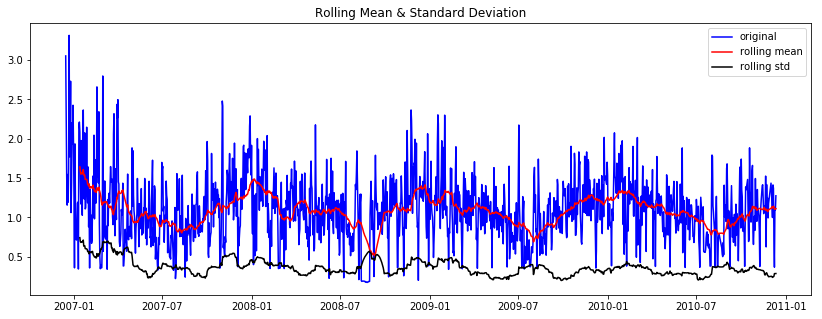

In [44]:
rolling_mean = df3.rolling(window=30).mean()
rolling_std = df3.rolling(window=30).std()

#plotting rolling statistics
plt.figure(figsize=(14,5))
plt.plot(df3,color='blue', label='original')
plt.plot(rolling_mean,color='red', label='rolling mean')
plt.plot(rolling_std,color='black', label='rolling std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

### Fitting LSTM

using a multi-layered LSTM recurrent neural network to predict the last sequence of values.

#### pre-processing and feature engineering for LSTM model:

In [48]:
from sklearn.preprocessing import MinMaxScaler

In [60]:
#Create the dataset
dataset = df.Global_active_power.values #numpy.ndarray
dataset = dataset.astype('float32')#ensure all data is float
dataset = np.reshape(dataset, (-1, 1))

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

#Split into training and test sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size

#Convert an array of values into a dataset matrix
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

#Reshape into X=t and Y=t+1
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [61]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

#### Model Architecture

Define the LSTM with 100 neurons in the first hidden layer and 1 neuron in the output layer for predicting Global_active_power. The input shape will be 1 time step with 30 features.

Dropout 20%

Use the MSE loss function and the efficient Adam version of stochastic gradient descent

The model will be fit for 20 training epochs with a batch size of 70

In [52]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [62]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Train on 1639393 samples, validate on 409825 samples
Epoch 1/20
1639393/1639393 [==============================] - 72s 44us/step - loss: 7.5110e-04 - val_loss: 4.4802e-04
Epoch 2/20
1639393/1639393 [==============================] - 74s 45us/step - loss: 6.6554e-04 - val_loss: 4.6173e-04
Epoch 3/20
1639393/1639393 [==============================] - 76s 46us/step - loss: 6.5333e-04 - val_loss: 4.3986e-04
Epoch 4/20
1639393/1639393 [==============================] - 71s 43us/step - loss: 6.4863e-04 - val_loss: 4.3576e-04
Epoch 5/20
1639393/1639393 [==============================] - 69s 42us/step - loss: 6.4326e-04 - val_loss: 4.4231e-04
Epoch 6/20
1639393/1639393 [==============================] - 75s 46us/step - loss: 6.3872e-04 - val_loss: 4.3109e-04
Epoch 7/20
1639393/1639393 [==============================] - 75s 46us/step - loss: 6.3627e-04 - val_loss: 4.3876e-04
Epoch 8/20
1639393/1639393 [==============================] - 74s 45us/step - loss: 6.3505e-04 - val_loss: 4.2635e-04
Epo

Predictions

In [63]:
train_predict = model.predict(X_train)
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])

test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.11633875490978207
Train Root Mean Squared Error: 0.26807994718994194
Test Mean Absolute Error: 0.10213258169018372
Test Root Mean Squared Error: 0.22271831604559608


Actual vs. Prediction

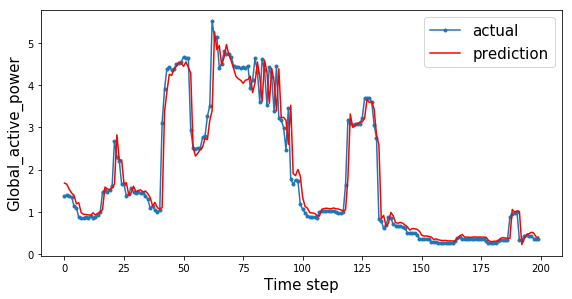

In [64]:
x_range=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(x_range, Y_test[0][:200], marker='.', label="actual")
plt.plot(x_range, test_predict[:,0][:200], 'r', label="prediction")


plt.tight_layout()
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

actual vs prediction are almost same

LSTM is a powerful tool for time series forecasting